# Handling and Visualizing a Dataset in Python

This notebook provides an example of how to load, read, and visualize a dataset.

# Description Dataset

This dataset originates from turbine optimization simulations and is stored in a series of text files. Each file captures specific attributes for 1,000 unique turbine blade designs, with each design evaluated at three different operational points: part load (tl, German: Teillast), nominal load (n), and full load (vl, German: Volllast). Each individual in the dataset represents a distinct turbine blade geometry, optimized across these operational conditions.

For a more comprehensive explanation of the optimization process, including the parameterization of the turbine and detailed methodology, refer to the related paper: https://doi.org/10.1002/pamm.202400126.

The dataset includes the following key parameters:

Key Parameters (Objectives of the Optimization):

    - eta (η): Efficiency, normalized between 0 and 1, indicating the performance of the turbine.
    - VCav: Cavitation volume, measured in cubic meters (m³), reflecting the extent of cavitation in the turbine.
    - dH (ΔH): Difference in the design head between the desired and computed value, measured in meters (m).
    
For each individual, these parameters are provided at three operational points:

    - tl: Part load (Teillast).
    - n: Nominal load.
    - vl: Full load (Volllast).
    
Fitness Evaluation:

The fitness of each individual is calculated based on three key metrics:
    - The average efficiency across the three operational points.
        - 1−mean(η[′tl′],η[′n′],η[′vl′])
    - The average cavitation volume across the operational points.
        - mean(VCav[′tl′],VCav[′n′],VCav[′vl′])
    - The average deviation in the design head across the operational points.
        - mean(dH[′tl′],dH[′n′],dH[′vl′])
    
    
Design Parameters (Inputs):

The design parameters describe the geometry of the turbine blade and were originally referred to as "objectives." However, to better align with machine learning practices, we going to rename these parameters during data loading process the to "input". These inputs, stored in data['input'], correspond to specific geometric features of the turbine blade. The labels of these parameters are provided in the variable parameter_labels.
    - The input data contains 30 design parameters for each individual, describing the geometry of the turbine blades.

## 1. Import Required Libraries

In [1]:
import os
import glob
import numpy as np
import ast
import matplotlib.pyplot as plt
from typing import List, Dict, Union

In [19]:
# Optional: Only required if you need to use the non-dominated sorting algorithm employed during optimization
# try:
#     import pygmo as pg
# except:
#     !pip install pygmo

## 1. Import dataset

In [3]:
# Define the paths of the data
# Assuming the data directory is the current working directory.
DATADIR = './runData'

In [4]:
# This is the order of the 30 geometry parameters
parameter_labels = [
    'alpha_0', 'alpha_1', 'alpha_2', 
    'beta_0', 'beta_1', 'beta_2',
    'M_0', 'M_1', 'M_2', 
    'r_0', 'r_1', 'r_2',
    'phi_r_0', 'phi_r_1', 'phi_r_2',
    'l_0', 'l_1', 'l_2',
    't_le_0', 't_le_1', 't_le_2',
    't_m_0', 't_m_1', 't_m_2',
    't_te_0', 't_te_1', 't_te_2', 
    'u_m_0', 'u_m_1', 'u_m_2'
]

In [5]:
# Function to read the numerical data from the files
def read_numerical_data(file_path: str) -> np.ndarray:
    """
    Reads numerical data from a file. Each line is expected to be a sequence of numbers.
    
    Args:
    file_path (str): The path to the file to be read.
    
    Returns:
    np.ndarray: A NumPy array of the numerical data.
    """
    return np.loadtxt(file_path)

In [6]:
# Function to read the dictionary-like data from the files

def read_dict_data(file_path: str) -> List[Dict[str, float]]:
    """
    Reads a file with dictionary-like content (e.g., {'tl': val, 'n': val, 'vl': val}).
    Each line in the file is a dictionary.
    
    Args:
    file_path (str): The path to the file to be read.
    
    Returns:
    List[Dict[str, float]]: A list of dictionaries for each row in the file.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = []
        for line in file:
            try:
                parsed_line = ast.literal_eval(line.strip())
                data.append(parsed_line)
            except Exception as e:
                print(f"Error parsing line: {line}, Error: {e}")
        return data

In [7]:
def read_all_data() -> Dict[str, Union[List[Dict[str, float]], np.ndarray]]:
    """
    Reads all required data (P, dH, eta, VCav, islandID, objective, fitness) from multiple files
    and stores them in a dictionary.
    
    Returns:
    Dict[str, Union[List[Dict[str, float]], np.ndarray]]: A dictionary with all the data concatenated.
    """
    data = {}
    
    # Helper function to read and concatenate dictionary-type data from multiple files
    def read_and_concatenate_dict(file_prefix: str) -> List[Dict[str, float]]:
        """Reads and concatenates dictionary data from multiple files."""
        all_data = []
        # Loop through all matching files (e.g., 'P.0', 'P.1', 'P.2', ...)
        for file in sorted(glob.glob(os.path.join(DATADIR, file_prefix + '.*'))):
            all_data.extend(read_dict_data(file))  # Append the data from each file
        return all_data

    # Helper function to read and concatenate numerical-type data from multiple files
    def read_and_concatenate_numeric(file_prefix: str) -> np.ndarray:
        """Reads and concatenates numerical data from multiple files, handles different row sizes."""
        all_data = []
        # Loop through all matching files (e.g., 'objective.0', 'objective.1', ...)
        for file in sorted(glob.glob(os.path.join(DATADIR, file_prefix + '.*'))):
            file_data = read_numerical_data(file)
            all_data.append(file_data)
        return np.concatenate(all_data, axis=0)  # Concatenate along rows, handling varying row sizes

    # Helper function to read and concatenate 1D numeric data (for islandID)
    def read_and_concatenate_1d(file_prefix: str) -> np.ndarray:
        """Reads and concatenates 1D numeric data (e.g., islandID) from multiple files."""
        all_data = []
        # Loop through all matching files (e.g., 'islandID.0', 'islandID.1', ...)
        for file in sorted(glob.glob(os.path.join(DATADIR, file_prefix + '.*'))):
            file_data = read_numerical_data(file).flatten()  # Ensure the data is 1D
            all_data.append(file_data)
        return np.hstack(all_data)  # Horizontally stack all the 1D arrays

    # Reading dictionary-type files (concatenating across multiple files)
    data['P']    = read_and_concatenate_dict('P')  # Read all 'P.*' files
    data['dH']   = read_and_concatenate_dict('dH')  # Read all 'dH.*' files
    data['eta']  = read_and_concatenate_dict('eta')  # Read all 'eta.*' files
    data['VCav'] = read_and_concatenate_dict('VCav')  # Read all 'VCav.*' files

    # Reading numerical-type file (concatenating across multiple files)
    
    # NOTE: The 30 design parameters that describe the geometry of the blade were initially referred to as "objectives".
    # In the context of optimization problems, "objectives" typically refer to the outputs or target metrics that we aim to optimize.
    # However, since these design parameters are inputs to the model (rather than optimization targets), it is more appropriate to rename 
    # them to "input" for clarity, especially in the context of machine learning datasets where inputs are features used to make predictions.

    data['input'] = read_and_concatenate_numeric('objective')  # Read all 'objective.*' files
    data['islandID'] = read_and_concatenate_1d('islandID')  # Read all 'islandID.*' files (1D array)

    # Reading fitness data (concatenating across multiple files)
    data['fitness'] = read_and_concatenate_numeric('fitness')  # Read all 'fitness.*' files (3 values per row)
    
    return data


## Load the dataset
All necassary functions to load the dataset are defined, lets load the data to a dicc

In [8]:
data = read_all_data()

# Identifying Successful Individuals and Extracting the Pareto Front
In this section, we will use the previously loaded turbine optimization data to identify individuals that successfully completed the simulation. These successful individuals are distinguished by having a valid fitness score, while failed individuals exhibit a fitness value exceeding 1×103081×10308 or NaN values.
Key Steps:

    - Filter Successful and Failed Individuals: We will separate successful individuals from those whose simulations failed based on their fitness values. This step ensures that only valid turbine designs are considered for further analysis.

    - Track Island and Generation Information: The optimization simulations were performed using an island model, where individuals evolve over several generations. We'll retrieve the generation number for each individual across multiple islands, helping us understand their progress through the optimization process.

    - Pareto Front Extraction: From the pool of successful individuals, we will focus on constructing the Pareto front. This front represents the set of optimal turbine designs that offer the best trade-offs between multiple objectives, such as maximizing efficiency while minimizing cavitation volume and hydraulic head difference.

By filtering out failed individuals and focusing on successful solutions, this process will allow us to identify and analyze the most promising designs within the optimization landscape.

## Filter Successful and Failed Individuals

In [9]:
def filter_successful_failed(data, threshold=1e+308):
    """
    Filters successful and failed individuals based on fitness values using the provided data dictionary.

    Parameters:
    - data: Dictionary containing the dataset (including 'input', 'fitness', 'P', 'dH', 'eta', 'vCav')
    - threshold: Fitness value above which individuals are considered failed (default: 1e+308)
    
    Returns:
    - success_indices: Indices of successful individuals
    - failed_indices: Indices of failed individuals
    """
    # Extract fitness and assume indices from 0 to len(fitness)-1
    fitness = data['fitness']
    IDs = np.arange(len(fitness))  # Use sequential indices for the fitness data
    
    # Check for success: all fitness values must be below the threshold and no NaN in the first fitness column
    is_success = np.all(fitness < threshold, axis=1) & (~np.isnan(fitness[:, 0]))
    
    # Get indices of successful and failed individuals
    success_indices = IDs[is_success]
    failed_indices = IDs[~is_success]
    
    return success_indices, failed_indices


In [10]:
# Function to filter dictionary data based on indices
def filter_dict_by_indices(data_dict, indices):
    """
    Filters a dictionary based on provided indices.

    Parameters:
    - data_dict: Dictionary to filter (e.g., data['P'])
    - indices: List or array of indices to keep

    Returns:
    - A list of filtered values from the dictionary
    """
    return [data_dict[i] for i in indices if i in data_dict]

In [11]:
# Example usage:
success_indices, failed_indices = filter_successful_failed(data)

We can filter the dataset based on successful and failed simulations using the provided indices. Below is an example of how to extract the fitness values for both successful and failed turbines. For dictionary-based data (such as power, efficiency, and cavitation volume), we need to loop over the indices to extract the relevant values, which is really slow. However, for this tutorial, we demonstrate this approach for clarity.

Alternatively, we could calculate efficiency, cavitation volume, and head difference directly from the fitness values (see function "plot_pareto_3d") if the mean values (as stored in the fitness array) are sufficient for your analysis, potentially speeding up the process.

In [12]:
# Filtered fitness values for successful and failed turbines
fitness_success = data['fitness'][success_indices]
fitness_failed  = data['fitness'][failed_indices]

In [13]:
# # Extract power data (P) for successful and failed turbines
# power_success = filter_dict_by_indices(data['P'], success_indices)
# power_failed  = filter_dict_by_indices(data['P'], failed_indices)

# # Extract efficiency (eta) for successful and failed turbines
# efficency_success = filter_dict_by_indices(data['eta'], success_indices)
# efficency_failed  = filter_dict_by_indices(data['eta'], failed_indices)

# # Extract cavitation volume (VCav) for successful and failed turbines
# caviatiation_volume_success = filter_dict_by_indices(data['VCav'], success_indices)
# caviatiation_volume_failed  = filter_dict_by_indices(data['VCav'], failed_indices)

# # Extract input geometry for successful and failed turbines
# input_geometry_success = filter_dict_by_indices(data['input'], success_indices)
# input_geometry_failed = filter_dict_by_indices(data['input'], failed_indices)

## Pareto Front Extraction
Applying Fast Non-Dominated Sorting to Identify the Pareto Front

In multi-objective optimization problems, the goal is often to find a set of solutions that represent the best trade-offs between competing objectives. In this case, we aim to identify the Pareto front of turbine designs based on three fitness metrics:

    - Efficiency (eta)
    - Cavitation volume (VCav)
    - Hydraulic head difference (dH)

The Pareto front consists of solutions that are not dominated by any other solution. A solution is said to dominate another if it is at least as good in all objectives and better in at least one. The first Pareto front (index 0) contains the non-dominated solutions, which represent the best trade-offs across the fitness metrics.
Fast Non-Dominated Sorting:

We will use the fast_non_dominated_sorting algorithm from the pygmo library to classify the individuals into different fronts based on their fitness values. 

    - Pareto front 0 (index 0): This front contains all individuals that are non-dominated by any other individual in the population. These solutions represent the most optimal trade-offs between the objectives. No solution in this front is strictly better than another across all objectives.

    - Pareto front 1 (index 1): This front contains individuals that would be non-dominated if we exclude the individuals from Pareto front 0. These solutions are dominated only by individuals in the first front and represent the second-best trade-offs.

    - Pareto front 2 (index 2) and beyond: Each subsequent front contains individuals that are dominated by the individuals in all previous fronts but are non-dominated within their own front.

In [14]:
def get_pareto_front(points):
    """
    Identify the Pareto front from a set of points.

    Parameters:
    - points (np.ndarray): An n x 3 array where each row represents 
                           the fitness values for three objectives.

    Returns:
    - pareto_front (np.ndarray): A subset of 'points' representing the Pareto front.
    """
    # Ensure the input is a NumPy array
    points = np.array(points)
    
    # Number of points
    n_points = points.shape[0]
    
    # Initialize a boolean array to mark Pareto front members
    is_pareto = np.ones(n_points, dtype=bool)
    
    for i in range(n_points):
        if is_pareto[i]:
            # Compare the current point to all other points
            # A point j dominates point i if all objectives of j <= i and at least one < 
            domination = np.all(points <= points[i], axis=1) & np.any(points < points[i], axis=1)
            # Exclude self-comparison
            domination[i] = False
            if np.any(domination):
                is_pareto[i] = False
    
    # Extract Pareto front points
    pareto_front = points[is_pareto]
    return pareto_front

In [15]:
fitness_pareto = get_pareto_front(fitness_success)

In [16]:
# # Apply fast non-dominated sorting to the fitness values
# # This will group the individuals into Pareto fronts
# ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(fitness_success)

# pareto_front_idx = 0
# fitness_pareto = fitness_success[ndf[pareto_front_idx]]

# Visualization


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_pareto_3d(Fitness, elev=30, azim=120, cmap=None):


    eta_values = []
    vCav_values = []
    dh_values = []
    
    length_pareto = len(Fitness)
    
    for i in range(length_pareto):
        eta = 1 - Fitness[i, 0]
        vCav = 1e3 * Fitness[i, 1]  # Convert volume from cubic meters [m^3] to liters [L] for visualization purposes
        dh = Fitness[i, 2]

        eta_values.append(eta)
        vCav_values.append(vCav)
        dh_values.append(dh)

    # Convert vCav values to log scale manually
    log_vCav_values = np.log10(vCav_values)

    # Set up the 3D plot with a suitable figure size for papers
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Set the perspective with view_init
    ax.view_init(elev=elev, azim=azim)

    # Use the provided cmap or default to 'viridis' if none is provided
    if cmap is None:
        cmap = cm.viridis

    # Create a color map based on the z-values (dh_values)
    norm = plt.Normalize(min(dh_values), max(dh_values))

    # Plot 3D points and their projection onto the x-y plane (z=0)
    for i in range(length_pareto):
        # Get the color based on the z-value (dh_values)
        color = cmap(norm(dh_values[i]))

        # Plot the 3D point
        ax.scatter(eta_values[i], log_vCav_values[i], dh_values[i], 
                   color=color, s=50, alpha=1.0, edgecolor='k')

        # Plot the line connecting the 3D point to its projection on the x-y plane (z=0)
        ax.plot([eta_values[i], eta_values[i]],  # x-coordinates
                [log_vCav_values[i], log_vCav_values[i]],  # y-coordinates
                [dh_values[i], 0],  # z-coordinates (dh_values -> 0)
                color=color, linestyle='--', linewidth=1.5, alpha=0.8)

    # Set axis labels with improved font size and formatting for a paper
    ax.set_xlabel('$\eta\,[-]$', fontsize=14, labelpad=12)
    ax.set_ylabel('$\log_{10}(V_{cav}\,[l])$', fontsize=14, labelpad=12)
    ax.set_zlabel('$\Delta H\,[m]$', fontsize=14, labelpad=12)

    # Set ticks and tick parameters for better readability
    ax.tick_params(axis='both', which='major', labelsize=14)
#     ax.tick_params(axis='z', labelsize=14)

    # Add grid for better clarity
    ax.grid(True)


    # Adjust the z-axis limit if needed
    ax.set_zlim([0, max(dh_values) * 1.1])

    # Optional axis inversion
    ax.invert_xaxis()
    ax.invert_yaxis()

    # Tight layout for better space management
    plt.tight_layout()

    plt.savefig('pareto_3d.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()



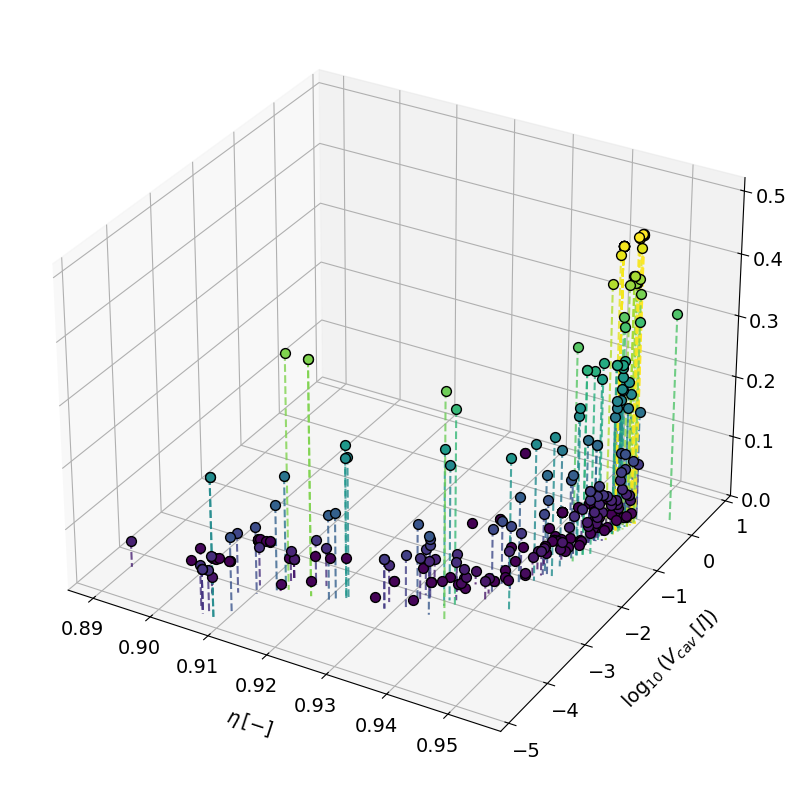

In [18]:
plot_pareto_3d(fitness_pareto)